# Projet Apprentissage Profond

## 1. Chargement des données

In [1]:
!git clone https://github.com/Spiroxx/projet_ap.git

Cloning into 'projet_ap'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 210 (delta 4), reused 13 (delta 2), pack-reused 188 (from 1)
Receiving objects: 100% (210/210), 63.67 MiB | 13.02 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (154/154), done.


In [2]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.

In [10]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('projet_ap/data.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'DATA' and  data[0] != 'TEST':
			box = [float(data[2]), float(data[3]), float(data[4]), float(data[5])]
			new_entry = {'type': data[0], 'path': data[1], 'shape': [float(data[6]), float(data[7])], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
#class_labels = list(dict.fromkeys([item['specie'] for item in dataset]))
#num_classes = len(class_labels)

# Extraction des données d'apprentissage et de test
dataset_train = [item for item in dataset if item['type']=='TRAIN']
dataset_test = [item for item in dataset if item['type']=='TEST']

#print(class_labels)

In [17]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('projet_ap/data/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0]))/img_shape[0]
    by = (box[1] + (box[3] - box[1]))/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    #label = class_labels.index(item['specie'])
    #classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    #y[i, 5:] = classes_probabilities

    i = i+1

  return x, y

Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [18]:
from sklearn.model_selection import train_test_split


# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 640

# Lecture des données d'entraînement et de test
x, y = build_localization_tensors(IMAGE_SIZE, dataset_train, 1)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, 1)

#Extraction d'un ensemble de validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

Box raw values: [-1.18300035 -0.24461165 -0.56265133 -0.29404251]
Dénormalisées: 144.4982698961938 317.7854671280277 17.43944636678206 37.64705882352949


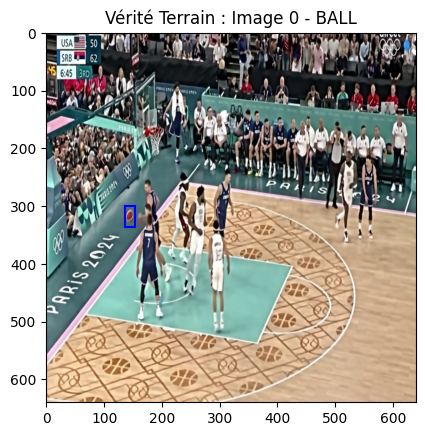

Box raw values: [-1.28023675  1.04546349 -0.19825805 -0.48917492]
Dénormalisées: 130.79584775086505 453.4256055363322 21.176470588235322 34.32525951557094


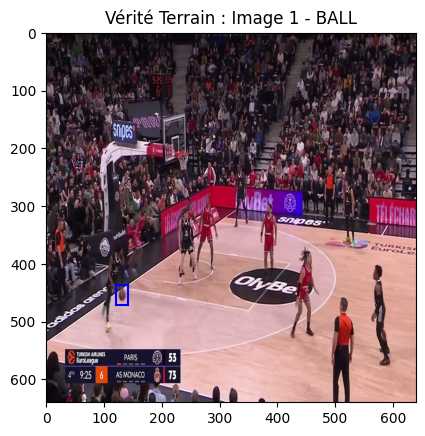

Box raw values: [ 0.2070383   0.81904214 -0.62338354 -0.29404251]
Dénormalisées: 340.3806228373702 429.61937716262975 16.816608996539742 37.64705882352933


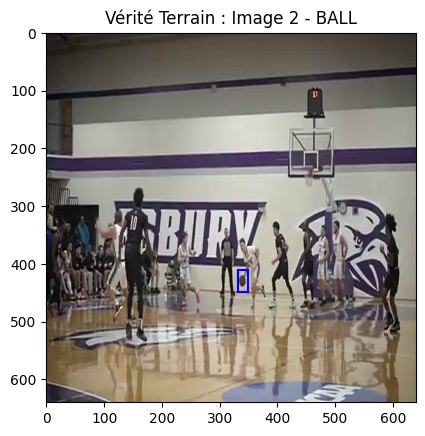

Box raw values: [ 1.16835279  0.48730853 -0.80558018 -1.1396163 ]
Dénormalisées: 475.8477508650518 394.7404844290657 14.94809688581313 23.25259515570933


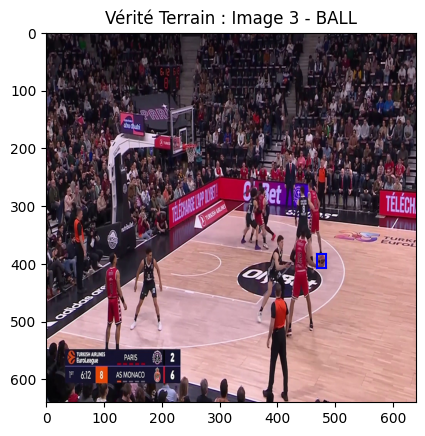

Box raw values: [ 0.03908451 -0.16562746 -0.13752584 -0.22899837]
Dénormalisées: 316.71280276816606 326.08996539792395 21.79930795847747 38.7543252595156


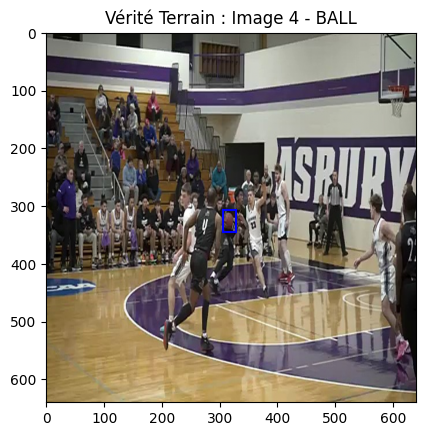

Box raw values: [ 1.50205046 -0.19195552  0.955654    1.2670168 ]
Dénormalisées: 522.8719723183391 323.3217993079585 33.010380622837374 64.2214532871972


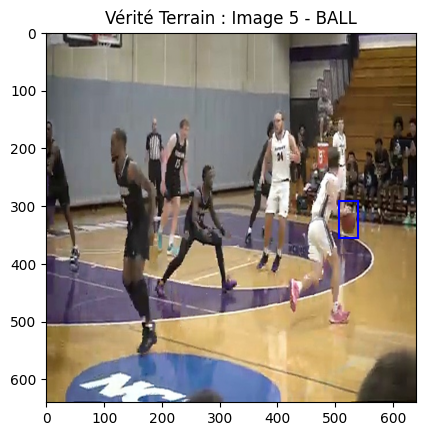

Box raw values: [ 0.31753422 -0.73957925 -0.01606141 -0.03386596]
Dénormalisées: 355.95155709342566 265.74394463667824 23.044982698961974 42.076124567474125


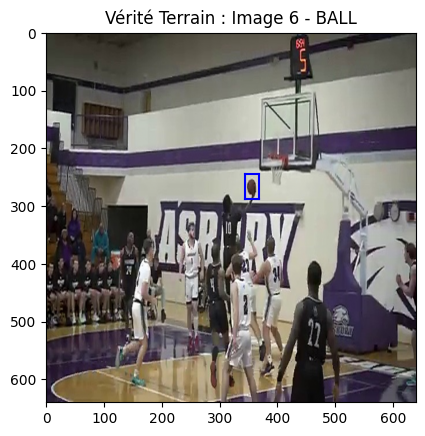

Box raw values: [-0.31229251  1.8721647  -0.19825805 -0.68430734]
Dénormalisées: 267.19723183391 540.3460207612457 21.176470588235212 31.003460207612417


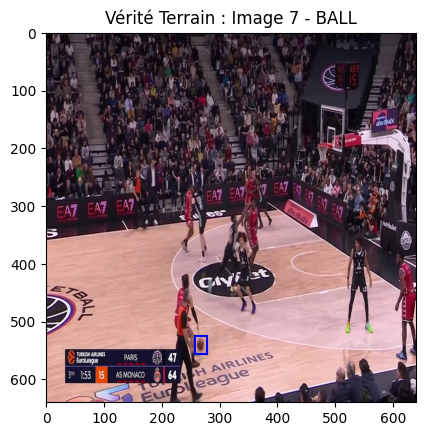

Box raw values: [-0.67471912  0.65054253 -0.68411576 -0.68430734]
Dénormalisées: 216.12456747404832 411.90311418685076 16.19377162629761 31.003460207612285


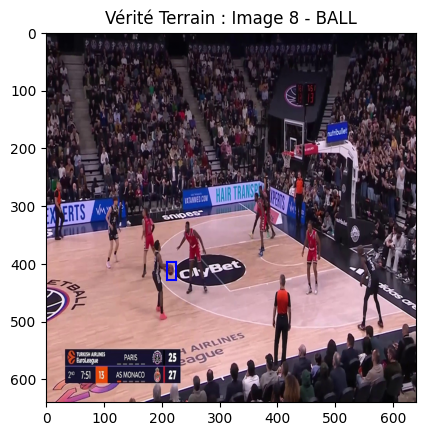

Box raw values: [ 1.47553144  0.82430775 -0.38045469 -0.35908665]
Dénormalisées: 519.1349480968859 430.17301038062277 19.307958477508766 36.53979238754329


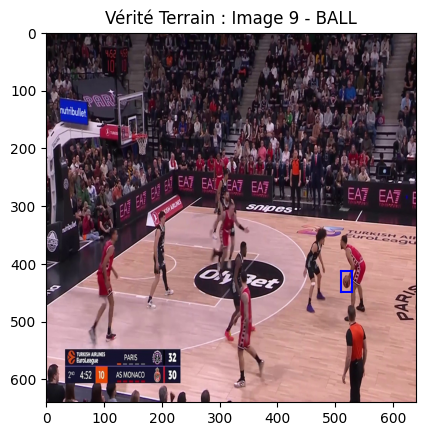

In [19]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=640):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id


  img = x[num_img]
  lab = y[num_img]

  colors = ["blue"] # Différentes couleurs pour les différentes classes
  classes = ['BALL']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  print("Box raw values:", lab[1:5])
  print("Dénormalisées:", ax, ay, width, height)
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)
